<a href="https://colab.research.google.com/github/Mostafa3zazi/CISC-873-DM-Data-Mining/blob/main/CISC_873_DM_F22_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CISC-873-DM-F22-A1: Wish.com Product Rating Prediction

#Download data from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install kaggle --upgrade

In [ ]:
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle --version

Kaggle API 1.5.4


In [ ]:
!kaggle competitions download -c cisc-873-dm-f22-a1

train_new.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_new.csv: Skipping, found more recently modified local copy (use --force to force download)
test_new.csv: Skipping, found more recently modified local copy (use --force to force download)


#Defining the problem
The goal is to predict the product ratings given the other features known for a product on Wish.com. Ratings are in categories from 1 to 5.

In [ ]:
#import libraries for data exploration and processing
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
#read train and test files
df_train = pd.read_csv('train_new.csv')
df_test = pd.read_csv('test_new.csv')

In [ ]:
df_train.head()

,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,theme,crawl_month,id
0,8.00,7,EUR,10000,1,4.0,1670,0,0,0,0,"Summer,soildcolor,Plus Size,Tank,camisole,Tops...",yellow,M,50,Livraison standard,3,0,30,50,NaN,NaN,CN,keepahorse,keepahorse,"88 % avis positifs (66,644 notes)",66644,4.137582,577fb2b368116418674befd9,1,https://s3-us-west-1.amazonaws.com/sweeper-pro...,summer,2020-08,272
1,8.00,7,EUR,1000,0,4.0,843,1,1,0,0,"bathing suit,Plus Size,bikini set,sexy swimsui...",black,L,50,Livraison standard,3,0,37,50,NaN,NaN,CN,shanghaimingqidianqikejiyouxiangongsi,上海铭启电气科技有限公司,"91 % avis positifs (25,752 notes)",25752,4.256873,566a3ef17233ff2686443082,0,NaN,summer,2020-08,1515
2,6.00,34,EUR,100,0,4.0,10,0,0,0,0,"Summer,Vest,momshirt,Get,summer t-shirts,funny...",white,L,50,Livraison standard,2,0,41,50,NaN,NaN,CN,zhaodongmei,zhaodongmei,"83 % avis positifs (3,897 notes)",3897,3.928920,5aacd6c1ccf0c83e5a6f3de0,0,NaN,summer,2020-08,940
3,4.67,4,EUR,100,1,3.0,82,0,0,0,0,"Summer,Shorts,pants,Beach,Plus Size,beachpant,...",lakeblue,XS,5,Livraison standard,1,0,25,50,NaN,NaN,CN,pookie0331,pookie0331,"87 % avis positifs (7,497 notes)",7497,4.079365,583141fbfef4094e51453d9b,0,NaN,summer,2020-08,309
4,8.00,11,EUR,1000,0,4.0,127,0,0,0,0,"Summer,Floral print,women dresses,fashion dres...",apricot,S,50,Livraison standard,3,0,15,50,1.0,Quantité limitée !,CN,shitongyi12683626,shitongyi12683626,91 % avis positifs (173 notes),173,4.306358,5d3bc9f8e13a7e654424a4cb,0,NaN,summer,2020-08,226


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price                         1094 non-null   float64
 1   retail_price                  1094 non-null   int64  
 2   currency_buyer                1094 non-null   object 
 3   units_sold                    1094 non-null   int64  
 4   uses_ad_boosts                1094 non-null   int64  
 5   rating                        1094 non-null   float64
 6   rating_count                  1094 non-null   int64  
 7   badges_count                  1094 non-null   int64  
 8   badge_local_product           1094 non-null   int64  
 9   badge_product_quality         1094 non-null   int64  
 10  badge_fast_shipping           1094 non-null   int64  
 11  tags                          1094 non-null   object 
 12  product_color                 1065 non-null   object 
 13  pro

some columns have so many null values so we will drop them <br>
like has_urgency_banner , urgency_text and merchant_profile_picture <br>
some columns are not relevat to our taks and like: <br>
id, merchant_title, merchant_name, merchant_info_subtitle merchant_has_profile_picture

##Inspect each column
here we inspect each column by using pandas value_counts function to find the value counts of each unique value. Then comment on the findings in a markdown cell below each column inspection.

In [ ]:
#price and ratial_price
df_train['price'].value_counts()

8.00     196
11.00    135
7.00      89
6.00      88
9.00      88
        ... 
25.00      1
5.70       1
3.90       1
4.69       1
4.73       1
Name: price, Length: 117, dtype: int64

In [ ]:
df_train['retail_price'].value_counts()

7      127
6      103
10      86
11      73
5       71
      ... 
87       1
139      1
37       1
53       1
57       1
Name: retail_price, Length: 95, dtype: int64

the ratial price should be heigher than or equla to the price so let's check

In [ ]:
(df_train['price'] > df_train['retail_price']).sum()

391

I think there are 391 entries that should be droped where price > ratail price

In [ ]:
#currency_buyer
df_train['currency_buyer'].value_counts()

EUR    1094
Name: currency_buyer, dtype: int64

currency_buyer should be dropped at it contains only one unique value

In [ ]:
#units_sold
df_train['units_sold'].value_counts()

100       353
1000      280
5000      139
10000     125
20000      79
50         54
10         37
50000      12
100000      5
8           4
1           3
2           2
7           1
Name: units_sold, dtype: int64

In [ ]:
#uses_ad_boosts
df_train['uses_ad_boosts'].value_counts()

0    621
1    473
Name: uses_ad_boosts, dtype: int64

In [ ]:
#raiting and raiting counts
df_train['rating'].value_counts()

4.0    774
5.0    170
3.0    135
2.0     12
1.0      2
6.0      1
Name: rating, dtype: int64

we have product with raiting 6!! ... must drop these values

In [ ]:
df_train['rating_count'].value_counts()

0       30
2       27
4       22
6       17
10      15
        ..
1183     1
370      1
569      1
4421     1
135      1
Name: rating_count, Length: 584, dtype: int64

the previous cell shows that there are 30 entries with zero rating count

In [ ]:
df_train[df_train['rating_count'] == 0][['rating','rating_count']]

,rating,rating_count
66,5.0,0
99,5.0,0
113,5.0,0
149,5.0,0
181,5.0,0
240,5.0,0
243,5.0,0
249,5.0,0
254,5.0,0
276,5.0,0


these entries have raiting of 5 so they should be dropped

In [ ]:
# badges_count , badge_local_product , badge_product_quality , badge_fast_shipping
df_train['badges_count'].value_counts()

0    979
1    106
2      8
3      1
Name: badges_count, dtype: int64

In [ ]:
df_train['badge_product_quality'].value_counts()

0    1003
1      91
Name: badge_product_quality, dtype: int64

In [ ]:
df_train['badge_product_quality'].value_counts()

0    1003
1      91
Name: badge_product_quality, dtype: int64

In [ ]:
df_train['badge_fast_shipping'].value_counts()

0    1081
1      13
Name: badge_fast_shipping, dtype: int64

We will check the correlation between these columns and the rating later on.

In [ ]:
#product_color
df_train['product_color'].value_counts()

black             219
white             173
blue               77
yellow             69
pink               68
                 ... 
claret              1
brown & yellow      1
whitestripe         1
Pink                1
light green         1
Name: product_color, Length: 87, dtype: int64

In [ ]:
#product_variation_size_id
df_train['product_variation_size_id'].value_counts().index

Index(['S', 'XS', 'M', 'XXS', 'L', 'S.', 'XL', 'XXL', 'XXXS', 'M.', 'Size-XS',
       'Size S', '4XL', 'XS.', 'Size-S', '2XL', '10 ml', 's', 'Size M', '35',
       'Size4XL', 'Size -XXS', 'SizeL', '25', 'SIZE XS', '29', 'S Pink',
       'XXXXXL', '33', '2pcs', '5', 'One Size', '20PCS-10PAIRS', '2',
       '4-5 Years', 'Size-5XL', '30 cm', '1 PC - XL', 'size S', 'Size/S', 'B',
       '20pcs', 'S..', 'Suit-S', 'Base & Top & Matte Top Coat',
       'Baby Float Boat', '1m by 3m', 'SIZE S', 'White', '40 cm', '5XL',
       '10pcs', 'Round', '1 pc.', '100 cm', '60', '26(Waist 72cm 28inch)',
       'S(bust 88cm)', 'choose a size', 'Base Coat',
       '100 x 100cm(39.3 x 39.3inch)', '1', '25-S', 'Size-XXS', '5PAIRS',
       'Pack of 1', '6XL', 'S/M(child)', 'S (waist58-62cm)', 'Size S.',
       'SIZE XXS', 'X   L', 'Women Size 36', '04-3XL',
       'Floating Chair for Kid', '34', 'US-S', 'Size XXS', 'pants-S', 'XXXXL',
       'SIZE-XXS', '1pc', 'H01'],
      dtype='object')

In [ ]:
df_train['product_variation_size_id'].value_counts()

S           444
XS          248
M           135
XXS          76
L            29
           ... 
pants-S       1
XXXXL         1
SIZE-XXS      1
1pc           1
H01           1
Name: product_variation_size_id, Length: 83, dtype: int64

I don't think product_variation_size_id will have great effect on rating

In [ ]:
#product_variation_inventory
df_train['product_variation_inventory'].value_counts()

50    626
1     114
2      54
5      51
3      38
10     26
9      17
7      15
4      14
6      12
18      9
17      9
15      9
20      8
13      6
25      6
49      5
19      5
14      5
46      4
11      4
8       4
30      4
29      4
44      4
48      3
47      3
36      3
45      3
34      3
41      3
35      2
12      2
40      2
26      2
31      2
43      2
38      2
24      1
33      1
22      1
21      1
27      1
16      1
23      1
28      1
37      1
Name: product_variation_inventory, dtype: int64

I think the counts of goods in inventroy won't affect the rating.

In [ ]:
#shipping_option_name
df_train['shipping_option_name'].value_counts()

Livraison standard         1047
Standard Shipping            16
Envio Padrão                  6
الشحن القياسي                 4
Expediere Standard            4
Envío normal                  3
Standardversand               3
Livraison Express             3
Standardowa wysyłka           2
Standart Gönderi              2
Стандартная доставка          2
Spedizione standard           1
ការដឹកជញ្ជូនតាមស្តង់ដារ       1
Name: shipping_option_name, dtype: int64

I think the shipping_option_names are the same but in different languages

In [ ]:
#shipping_option_price
df_train['shipping_option_price'].value_counts()

2     417
3     370
1     222
4      49
5      23
6       8
7       4
12      1
Name: shipping_option_price, dtype: int64

In [ ]:
#shipping_is_express
df_train['shipping_is_express'].value_counts()

0    1091
1       3
Name: shipping_is_express, dtype: int64

In [ ]:
#countries_shipped_to
df_train['countries_shipped_to'].value_counts()

41     122
43     112
40      82
38      51
36      48
      ... 
107      1
111      1
56       1
135      1
53       1
Name: countries_shipped_to, Length: 83, dtype: int64

In [ ]:
#inventory_total
df_train['inventory_total'].value_counts()

50    1089
1        1
9        1
37       1
2        1
36       1
Name: inventory_total, dtype: int64

the value 50 occures 1089 times and so this featrue won't have effect on the result

In [ ]:
#has_urgency_banner and urgency_text
df_train['has_urgency_banner'].value_counts()

1.0    349
Name: has_urgency_banner, dtype: int64

In [ ]:
df_train['urgency_text'].value_counts()

Quantité limitée !                  348
Réduction sur les achats en gros      1
Name: urgency_text, dtype: int64

has_urgency_banner has only one unique value (1)

this feature should have 2 unique values (1 and zero)

so I thing the nan should be filled with zeros

In [ ]:
#origin_country
df_train['origin_country'].value_counts()

CN    1054
US      22
VE       3
SG       2
GB       1
Name: origin_country, dtype: int64

In [ ]:
# merchant_rating_count & merchant_rating
df_train['merchant_rating'].value_counts()

4.045170    8
3.884544    7
3.867547    6
4.080891    6
3.908535    6
           ..
4.069536    1
4.316022    1
3.837956    1
4.256597    1
3.748794    1
Name: merchant_rating, Length: 742, dtype: int64

In [ ]:
df_train['merchant_rating_count'].value_counts()

12309    8
32168    7
88193    6
55670    6
80093    6
        ..
2946     1
2055     1
23609    1
36       1
6632     1
Name: merchant_rating_count, Length: 718, dtype: int64

In [ ]:
df_train['merchant_rating_count'].describe()

count    1.094000e+03
mean     2.678399e+04
std      8.616171e+04
min      4.000000e+00
25%      1.926000e+03
50%      8.225000e+03
75%      2.306200e+04
max      2.174765e+06
Name: merchant_rating_count, dtype: float64

no merchant_rating_count with zero value

In [ ]:
#theme
df_train['theme'].value_counts()

summer    1094
Name: theme, dtype: int64

only one unique value (must be dropped)

In [ ]:
#crawl_month
df_train['crawl_month'].value_counts()

2020-08    1094
Name: crawl_month, dtype: int64

only one unique value (must be dropped)

In [ ]:
df_train.duplicated().sum()

0

no duplicated

##summary

<pre>
 0   price                         	
 1   retail_price                  	
 2   currency_buyer                 drop(only one unique value)
 3   units_sold                    	
 4   uses_ad_boosts                	
 5   rating                        	drop rows with rate 6
 6   rating_count                  	drop rows with 0 value
 7   badges_count                  	not needes as we are going to keep the next three features
 8   badge_local_product           	
 9   badge_product_quality         	
 10  badge_fast_shipping           	
 11  tags                           may be preprocessed with one hot encoding or label encoding
 12  product_color                 	may be preprocessed with one hot encoding or label encoding
 13  product_variation_size_id     	may be preprocessed with one hot encoding or label encoding
 14  product_variation_inventory    drop (not useful to our task)
 15  shipping_option_name           drop (same value with different languages)
 16  shipping_option_price         	
 17  shipping_is_express           	
 18  countries_shipped_to          	may be preprocessed with one hot encoding or label encoding
 19  inventory_total               	drop (not useful to our task)
 20  has_urgency_banner            	can fill nan with zeros or dropped
 21  urgency_text                  	drop (not useful to our task)
 22  origin_country                	may be preprocessed with one hot encoding or label encoding
 23  merchant_title                	drop (not useful to our task)
 24  merchant_name                 	drop (not useful to our task)
 25  merchant_info_subtitle        	drop (not useful to our task)
 26  merchant_rating_count         	drop (not useful to our task)
 27  merchant_rating               	
 28  merchant_id                   	drop (not useful to our task)
 29  merchant_has_profile_picture  	drop (not useful to our task)
 30  merchant_profile_picture      	drop (not useful to our task)
 31  theme                         	drop(only one unique value)
 32  crawl_month                   	drop(only one unique value)
 33  id                            	drop (not useful to our task)
 </pre>

#Clean Data
Here we will drop useless column, noisy rows and check duplicates

In [ ]:
#features to be dropped
dropped_columns = ['currency_buyer','badges_count','shipping_option_name',
                   'inventory_total','product_variation_inventory','urgency_text',
                   'merchant_title','merchant_name','merchant_info_subtitle','merchant_rating_count',
                   'merchant_id','merchant_has_profile_picture','merchant_profile_picture','theme','crawl_month','id']
dropped_columns

['currency_buyer',
 'badges_count',
 'shipping_option_name',
 'inventory_total',
 'product_variation_inventory',
 'urgency_text',
 'merchant_title',
 'merchant_name',
 'merchant_info_subtitle',
 'merchant_rating_count',
 'merchant_id',
 'merchant_has_profile_picture',
 'merchant_profile_picture',
 'theme',
 'crawl_month',
 'id']

In [ ]:
df_train = df_train.drop(dropped_columns, axis=1)
df_train

,price,retail_price,units_sold,uses_ad_boosts,rating,rating_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_color,product_variation_size_id,shipping_option_price,shipping_is_express,countries_shipped_to,has_urgency_banner,origin_country,merchant_rating
0,8.00,7,10000,1,4.0,1670,0,0,0,"Summer,soildcolor,Plus Size,Tank,camisole,Tops...",yellow,M,3,0,30,NaN,CN,4.137582
1,8.00,7,1000,0,4.0,843,1,0,0,"bathing suit,Plus Size,bikini set,sexy swimsui...",black,L,3,0,37,NaN,CN,4.256873
2,6.00,34,100,0,4.0,10,0,0,0,"Summer,Vest,momshirt,Get,summer t-shirts,funny...",white,L,2,0,41,NaN,CN,3.928920
3,4.67,4,100,1,3.0,82,0,0,0,"Summer,Shorts,pants,Beach,Plus Size,beachpant,...",lakeblue,XS,1,0,25,NaN,CN,4.079365
4,8.00,11,1000,0,4.0,127,0,0,0,"Summer,Floral print,women dresses,fashion dres...",apricot,S,3,0,15,1.0,CN,4.306358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,4.00,4,10000,0,4.0,2150,0,0,0,"corset top,Fashion,crop top,camisole,knittop,T...",red,S,1,0,41,NaN,CN,4.311066
1090,5.00,5,1000,0,5.0,377,0,1,0,"Blues,Summer,luggagesticker,Bicycle,cute,fresh...",NaN,H01,2,0,35,NaN,CN,4.422521
1091,9.00,48,1000,1,4.0,135,0,0,0,"Summer,Vest,Fashion,Tank,camisole,Halter,Beaut...",purple,M,3,0,25,NaN,CN,3.748794
1092,11.00,10,10000,1,4.0,1479,0,0,0,"Summer,Shorts,Cotton,Cotton T Shirt,letter pri...",black,M,2,0,45,1.0,CN,3.936382


In [ ]:
# drop rows with rating = 6 and rows with rating_count = 0
df_train = df_train[df_train['rating'] != 6] 
df_train = df_train[df_train['rating_count'] != 0]

In [ ]:
#features may be used with one hot encoding or label encoding
need_encoding_columns = ['tags','product_color','product_variation_size_id',
                         'countries_shipped_to','origin_country']

In [ ]:
#features may be filled with values
to_fill_columns = ['has_urgency_banner']

In [ ]:
df_train.isna().sum()

price                          0
retail_price                   0
units_sold                     0
uses_ad_boosts                 0
rating                         0
rating_count                   0
badge_local_product            0
badge_product_quality          0
badge_fast_shipping            0
tags                           0
product_color                 26
product_variation_size_id     12
shipping_option_price          0
shipping_is_express            0
countries_shipped_to           0
has_urgency_banner           723
origin_country                12
merchant_rating                0
dtype: int64

#Trials
Steps:
1. describing the trial (what we are going to do)
2. preprocess the training data
3. use gridSearch to try different models
4. inspect the results 

But first we import our models, scalers,... etc

And prepare some function to help us.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def x_y_split(df,y_lables = 'rating'):
  return df.iloc[:, df.columns != y_lables] , df[y_lables]

## Trial 1 (drop all nominal)
* drop all nominal catigorical features (no encoding)
* prepare data (drop nominal columns and has_urgency_banner column)
* use gridsearch
* inspect results 


### prepare data

In [ ]:
df_trail_1 = df_train.copy()

In [ ]:
#drop nominal columns
df_trail_1 = df_trail_1.drop(need_encoding_columns,axis = 1)
#drop has_urgency_banner 
df_trail_1 = df_trail_1.drop(to_fill_columns,axis = 1)

In [ ]:
df_trail_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 0 to 1093
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  1063 non-null   float64
 1   retail_price           1063 non-null   int64  
 2   units_sold             1063 non-null   int64  
 3   uses_ad_boosts         1063 non-null   int64  
 4   rating                 1063 non-null   float64
 5   rating_count           1063 non-null   int64  
 6   badge_local_product    1063 non-null   int64  
 7   badge_product_quality  1063 non-null   int64  
 8   badge_fast_shipping    1063 non-null   int64  
 9   shipping_option_price  1063 non-null   int64  
 10  shipping_is_express    1063 non-null   int64  
 11  merchant_rating        1063 non-null   float64
dtypes: float64(3), int64(9)
memory usage: 108.0 KB


In [ ]:
df_trail_1.isna().sum()

price                    0
retail_price             0
units_sold               0
uses_ad_boosts           0
rating                   0
rating_count             0
badge_local_product      0
badge_product_quality    0
badge_fast_shipping      0
shipping_option_price    0
shipping_is_express      0
merchant_rating          0
dtype: int64

In [ ]:
df_trail_1_x, df_trail_1_y = x_y_split(df_trail_1)

In [ ]:
df_trail_1_y.value_counts()

4.0    774
5.0    140
3.0    135
2.0     12
1.0      2
Name: rating, dtype: int64

###GridSearch
we will try three models with different parameters:
1. SVM
2. Decision tree
3. GradientBoostingClassifier

In [ ]:
#Scaling Data
scaler = preprocessing.StandardScaler()
df_trail_1_x_scaled = scaler.fit_transform(df_trail_1_x)

####SVC

In [ ]:
#SVC parameters
SVC_linear_parametres = {
    'C': [0.01],
    'kernel': ['linear']
}
SVC_poly_parametres = {
    'C': [0.01],
    'degree': [10],
    'kernel': ['poly']
}
SVC_rbf_parametres = {
    'C': [0.01, 0.1, 1, 10, 100, 1000,1e5],
    'gamma':['scale', 'auto'],
    'kernel': ['rbf']
}

In [ ]:
param_list = [SVC_linear_parametres , SVC_poly_parametres, SVC_rbf_parametres]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_1_x_scaled,df_trail_1_y)

#grid_search with F1-score
grid_search = GridSearchCV(SVC(), param_grid = param_list ,
                           refit = True, cv = cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_1_x_scaled,df_trail_1_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce51381a50>,
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01], 'kernel': ['linear']},
                         {'C': [0.01], 'degree': [10], 'kernel': ['poly']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000, 100000.0],
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
SVC_resutls = pd.DataFrame(grid_search.cv_results_)
SVC_best = [grid_search.best_score_ , grid_search.best_params_]
SVC_resutls[SVC_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.072762,0.002182,0.015862,0.000776,1,rbf,NaN,scale,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.746479,0.751174,0.746479,0.754717,0.750000,0.749770,0.003104,2,0.770588,0.768235,0.764706,0.770858,0.763807,0.767639,0.002922
7,0.071698,0.001448,0.016570,0.002183,1,rbf,NaN,auto,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.746479,0.751174,0.751174,0.754717,0.750000,0.750709,0.002642,1,0.769412,0.768235,0.763529,0.770858,0.763807,0.767168,0.002977
9,0.093251,0.005730,0.015706,0.000678,10,rbf,NaN,auto,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.727700,0.751174,0.741784,0.726415,0.754717,0.740358,0.011660,3,0.792941,0.795294,0.796471,0.799060,0.790834,0.794920,0.002839
10,0.178851,0.016603,0.016111,0.000518,100,rbf,NaN,scale,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.732394,0.741784,0.751174,0.726415,0.750000,0.740353,0.009693,4,0.840000,0.837647,0.829412,0.830787,0.830787,0.833727,0.004257


####Decision Tree

In [ ]:
#DecisionTreeClassifier()
dtreeparam_grid = {
    'criterion': ['gini'],
    'max_depth': np.arange(7,20),
    # 'min_samples_leaf': np.arange(10),
    'max_leaf_nodes': np.arange(40,70)
}

In [ ]:
param_list = [dtreeparam_grid]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_1_x_scaled,df_trail_1_y)

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_1_x_scaled,df_trail_1_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 390 candidates, totalling 1950 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce52074cd0>,
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini'],
                          'max_depth': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                          'max_leaf_nodes': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
DecisionTree_resutls = pd.DataFrame(grid_search.cv_results_)
DecisionTree_best = [grid_search.best_score_ , grid_search.best_params_]
DecisionTree_resutls[DecisionTree_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
40,0.006577,0.002977,0.002694,0.000626,gini,8,50,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.774648,0.760563,0.784038,0.787736,0.792453,0.779888,0.011292,2,0.841176,0.851765,0.855294,0.846063,0.848414,0.848542,0.004825
44,0.008290,0.002008,0.003667,0.001838,gini,8,54,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.760563,0.769953,0.784038,0.787736,0.797170,0.779892,0.013035,1,0.847059,0.854118,0.857647,0.848414,0.849589,0.851365,0.003936
50,0.010312,0.004165,0.003149,0.001013,gini,8,60,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.755869,0.760563,0.788732,0.792453,0.797170,0.778957,0.017209,3,0.849412,0.854118,0.861176,0.850764,0.850764,0.853247,0.004259
55,0.004862,0.000129,0.002150,0.000050,gini,8,65,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.760563,0.769953,0.779343,0.787736,0.797170,0.778953,0.012871,4,0.851765,0.854118,0.860000,0.853114,0.851939,0.854187,0.003029


####GradientBoosting

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'n_estimators': np.arange(60,150,10),
    'learning_rate' : [0.2,0.1,0.01]

}

In [ ]:
param_list = [GBC]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_1_x_scaled,df_trail_1_y)

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_1_x_scaled,df_trail_1_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce5086a250>,
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.1, 0.01],
                          'n_estimators': array([ 60,  70,  80,  90, 100, 110, 120, 130, 140])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
GBC_resutls = pd.DataFrame(grid_search.cv_results_)
GBC_best = [grid_search.best_score_ , grid_search.best_params_]
GBC_resutls[GBC_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
12,1.320368,0.002742,0.005325,0.000149,0.1,90,"{'learning_rate': 0.1, 'n_estimators': 90}",0.760563,0.769953,0.769953,0.787736,0.820755,0.781792,0.021375,2,0.909412,0.917647,0.909412,0.891892,0.909518,0.907576,0.008461
14,1.613608,0.013246,0.005832,0.000150,0.1,110,"{'learning_rate': 0.1, 'n_estimators': 110}",0.755869,0.769953,0.769953,0.792453,0.816038,0.780853,0.021139,3,0.925882,0.923529,0.924706,0.908343,0.927145,0.921921,0.006895
15,1.740485,0.006232,0.006173,0.000133,0.1,120,"{'learning_rate': 0.1, 'n_estimators': 120}",0.751174,0.769953,0.774648,0.783019,0.820755,0.779910,0.022937,4,0.931765,0.929412,0.932941,0.916569,0.931845,0.928506,0.006079
16,1.900988,0.015074,0.006392,0.000146,0.1,130,"{'learning_rate': 0.1, 'n_estimators': 130}",0.751174,0.769953,0.774648,0.792453,0.825472,0.782740,0.025083,1,0.936471,0.934118,0.941176,0.924794,0.940071,0.935326,0.005838


###Inspect results

In [ ]:
print('SVC best f1-score:{0} , best prams:{1}'.format(SVC_best[0],SVC_best[1]))
print('DT best f1-score:{0} , best prams:{1}'.format(DecisionTree_best[0],DecisionTree_best[1]))
print('GBC best f1-score:{0} , best prams:{1}'.format(GBC_best[0],GBC_best[1]))

SVC best f1-score:0.7507086544423774 , best prams:{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
DT best f1-score:0.7798919301975374 , best prams:{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 54}
GBC best f1-score:0.7827398352378422 , best prams:{'learning_rate': 0.1, 'n_estimators': 130}


not bad for the first trial

the best model is GBC with mean test score = 0.78367

##Trial 2 (add has_urgency_banner)
* the same as trial one but we will add has_urgency_banner column and replace null values with zero.

###prepare data

In [ ]:
df_trail_2 = df_train.copy()

In [ ]:
#drop nominal columns
df_trail_2 = df_trail_2.drop(need_encoding_columns,axis = 1)

In [ ]:
df_trail_2.isna().sum()

price                      0
retail_price               0
units_sold                 0
uses_ad_boosts             0
rating                     0
rating_count               0
badge_local_product        0
badge_product_quality      0
badge_fast_shipping        0
shipping_option_price      0
shipping_is_express        0
has_urgency_banner       723
merchant_rating            0
dtype: int64

In [ ]:
df_trail_2.fillna(0,inplace = True)

In [ ]:
df_trail_2.isna().sum()

price                    0
retail_price             0
units_sold               0
uses_ad_boosts           0
rating                   0
rating_count             0
badge_local_product      0
badge_product_quality    0
badge_fast_shipping      0
shipping_option_price    0
shipping_is_express      0
has_urgency_banner       0
merchant_rating          0
dtype: int64

In [ ]:
df_trail_2_x, df_trail_2_y = x_y_split(df_trail_2)

###GridSearch
we will try three models with different parameters:
1. SVM
2. Decision tree
3. GradientBoostingClassifier

In [ ]:
#Scaling Data
scaler = preprocessing.StandardScaler()
df_trail_2_x_scaled = scaler.fit_transform(df_trail_2_x)

####SVC

In [ ]:
#SVC parameters
SVC_linear_parametres = {
    'C': [0.01],
    'kernel': ['linear']
}
SVC_poly_parametres = {
    'C': [0.01],
    'degree': [10],
    'kernel': ['poly']
}
SVC_rbf_parametres = {
    'C': [0.01, 0.1, 1, 10, 100, 1000,1e5],
    'gamma':['scale', 'auto'],
    'kernel': ['rbf']
}

In [ ]:
param_list = [SVC_linear_parametres , SVC_poly_parametres, SVC_rbf_parametres]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_2_x_scaled,df_trail_2_y)

#grid_search with F1-score
grid_search = GridSearchCV(SVC(), param_grid = param_list ,
                           refit = True, cv = cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_2_x_scaled,df_trail_2_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce5086aed0>,
             estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01], 'kernel': ['linear']},
                         {'C': [0.01], 'degree': [10], 'kernel': ['poly']},
                         {'C': [0.01, 0.1, 1, 10, 100, 1000, 100000.0],
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
SVC_resutls = pd.DataFrame(grid_search.cv_results_)
SVC_best = [grid_search.best_score_ , grid_search.best_params_]
SVC_resutls[SVC_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.073298,0.004082,0.016173,0.000300,1,rbf,NaN,scale,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.732394,0.751174,0.746479,0.745283,0.754717,0.746009,0.007597,2,0.771765,0.771765,0.768235,0.770858,0.768508,0.770226,0.001552
7,0.073871,0.003138,0.016589,0.000920,1,rbf,NaN,auto,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.732394,0.751174,0.746479,0.745283,0.759434,0.746953,0.008815,1,0.772941,0.771765,0.768235,0.770858,0.768508,0.770461,0.001832
8,0.095777,0.008375,0.018669,0.002709,10,rbf,NaN,scale,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.723005,0.755869,0.737089,0.731132,0.754717,0.740362,0.012990,3,0.801176,0.800000,0.801176,0.797885,0.794360,0.798919,0.002578
9,0.093663,0.003605,0.016986,0.001494,10,rbf,NaN,auto,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.723005,0.755869,0.732394,0.731132,0.754717,0.739423,0.013357,4,0.801176,0.801176,0.800000,0.797885,0.793184,0.798684,0.003001


####Decision Tree

In [ ]:
#DecisionTreeClassifier()
dtreeparam_grid = {
    'criterion': ['gini'],
    'max_depth': np.arange(7,20),
    # 'min_samples_leaf': np.arange(10),
    'max_leaf_nodes': np.arange(40,70)
}

In [ ]:
param_list = [dtreeparam_grid]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_2_x_scaled,df_trail_2_y)

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_2_x_scaled,df_trail_2_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 390 candidates, totalling 1950 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce5086af50>,
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini'],
                          'max_depth': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                          'max_leaf_nodes': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
DecisionTree_resutls = pd.DataFrame(grid_search.cv_results_)
DecisionTree_best = [grid_search.best_score_ , grid_search.best_params_]
DecisionTree_resutls[DecisionTree_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
38,0.004997,0.000186,0.002090,0.000081,gini,8,48,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.769953,0.760563,0.784038,0.783019,0.783019,0.776118,0.009359,3,0.840000,0.851765,0.854118,0.846063,0.846063,0.847602,0.004946
39,0.004623,0.000072,0.001847,0.000087,gini,8,49,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.769953,0.760563,0.779343,0.783019,0.787736,0.776123,0.009726,2,0.841176,0.851765,0.854118,0.846063,0.847239,0.848072,0.004527
44,0.005891,0.001724,0.002784,0.001532,gini,8,54,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.765258,0.765258,0.784038,0.783019,0.778302,0.775175,0.008325,4,0.847059,0.854118,0.857647,0.848414,0.849589,0.851365,0.003936
57,0.004979,0.000131,0.002311,0.000560,gini,8,67,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.769953,0.760563,0.774648,0.783019,0.792453,0.776127,0.010923,1,0.851765,0.855294,0.858824,0.853114,0.851939,0.854187,0.002638


####GradientBoosting

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'n_estimators': np.arange(60,150,10),
    'learning_rate' : [0.2,0.1,0.01]

}

In [ ]:
param_list = [GBC]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_2_x_scaled,df_trail_2_y)

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_2_x_scaled,df_trail_2_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce50804450>,
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.1, 0.01],
                          'n_estimators': array([ 60,  70,  80,  90, 100, 110, 120, 130, 140])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
GBC_resutls = pd.DataFrame(grid_search.cv_results_)
GBC_best = [grid_search.best_score_ , grid_search.best_params_]
GBC_resutls[GBC_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,1.929674,0.010277,0.006808,0.000876,0.2,140,"{'learning_rate': 0.2, 'n_estimators': 140}",0.737089,0.774648,0.779343,0.797170,0.792453,0.776140,0.021193,4,0.997647,0.995294,0.994118,0.992949,0.995300,0.995062,0.001559
11,1.191305,0.012165,0.005054,0.000165,0.1,80,"{'learning_rate': 0.1, 'n_estimators': 80}",0.755869,0.765258,0.769953,0.783019,0.806604,0.776140,0.017567,4,0.905882,0.901176,0.895294,0.893067,0.896592,0.898402,0.004584
12,1.341717,0.013653,0.005248,0.000093,0.1,90,"{'learning_rate': 0.1, 'n_estimators': 90}",0.746479,0.779343,0.769953,0.787736,0.806604,0.778023,0.019865,2,0.916471,0.914118,0.908235,0.901293,0.908343,0.909692,0.005292
13,1.475871,0.006835,0.007798,0.003999,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.746479,0.779343,0.779343,0.787736,0.806604,0.779901,0.019453,1,0.928235,0.917647,0.917647,0.907168,0.917744,0.917688,0.006662
14,1.630704,0.028258,0.007082,0.002176,0.1,110,"{'learning_rate': 0.1, 'n_estimators': 110}",0.746479,0.774648,0.774648,0.787736,0.806604,0.778023,0.019642,2,0.931765,0.922353,0.924706,0.918919,0.927145,0.924977,0.004346


###Inspect results

In [ ]:
print('SVC best f1-score:{0} , best prams:{1}'.format(SVC_best[0],SVC_best[1]))
print('DT best f1-score:{0} , best prams:{1}'.format(DecisionTree_best[0],DecisionTree_best[1]))
print('GBC best f1-score:{0} , best prams:{1}'.format(GBC_best[0],GBC_best[1]))

SVC best f1-score:0.7469527858977767 , best prams:{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
DT best f1-score:0.7761272034724069 , best prams:{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 67}
GBC best f1-score:0.7799007883780671 , best prams:{'learning_rate': 0.1, 'n_estimators': 100}


The F1-score decreased so for the upcomming trials we will drop has_urgency_banner column

## Trial 3 (add tage column)
* prepare tage column 
* prepare data (drop nominal columns and has_urgency_banner column then add tag column)
* use gridsearch (DT and GB only)
* inspect results 


###prepare tage column

In [ ]:
tags_column = df_train['tags']

In [ ]:
tags_column.isna().sum()

0

In [ ]:
tags_df = tags_column.str.get_dummies(',')
tags_df

,#Sport Bra,#fashion #shorts,#fashion #tshirt,#top #crop,2 Piece Swimsuit,2 piece dress sets,2014menshort,2014summermenshort,2018fashion,2in1short,2in1sportsjogging,2piecebathingsuit,2piecesbikini,2pieceset,34pant,34sleeve,34sleevedres,3D T-shirt,3dprint,3dprinttshirt,3mreflective,A line dress,A-line,Above Knee dresses,Accessories,Adidas,American,Angel,Animal,Ankle,Arms,Army,Athletics,Baby,Baby Girl,Backs,Bags,Bali,Balloon,Bandage Dresses,...,womenshortpant,womenshortspant,womensleepwearset,womensleevelessdres,womensportoutfit,womensportset,womensporttracksuit,womenssexyshort,womensummerclothe,womensummeroutfit,womensummersexybacklessbikini,womensummershort,womensummerswimwear,womenswimbottom,womenswimsit,womenswimwearbikini,womentee,womenunderwearsuit,workout top,workoutampyoga,workoutshortsformen,woven,wovenbag,wrap dress,wrapjumpsuit,wrappedchest,yoga leggings,yoga pants,yoga top,yoga2pcsset,yogaromper,yogashort,yogasuit,yogasuitset,yogateeshirt,yogavest,young,zippers,zippersleevelessvest,漁師の帽子
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1090,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1092,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


the result contains 2136 which is a huge number
we will reduce this number in another tiral.

### prepare data

In [ ]:
df_trail_3 = df_train.copy()

In [ ]:
#drop nominal columns
df_trail_3 = df_trail_3.drop(need_encoding_columns,axis = 1)
#drop has_urgency_banner 
df_trail_3 = df_trail_3.drop(to_fill_columns,axis = 1)

In [ ]:
#add tage encodes df
df_trail_3 = pd.concat([df_trail_3, tags_df], axis=1)

In [ ]:
df_trail_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 0 to 1093
Columns: 2148 entries, price to 漁師の帽子
dtypes: float64(3), int64(2145)
memory usage: 17.4 MB


In [ ]:
df_trail_3.isna().sum().sum()

0

In [ ]:
df_trail_3_x, df_trail_3_y = x_y_split(df_trail_3)

In [ ]:
df_trail_3_y.value_counts()

4.0    774
5.0    140
3.0    135
2.0     12
1.0      2
Name: rating, dtype: int64

###GridSearch
we will try three models with different parameters:
1. Decision tree
2. GradientBoostingClassifier

In [ ]:
#Scaling Data
scaler = preprocessing.StandardScaler()
df_trail_3_x_scaled = scaler.fit_transform(df_trail_3_x)

####Decision Tree

In [ ]:
#DecisionTreeClassifier()
dtreeparam_grid = {
    'criterion': ['gini'],
    'max_depth': np.arange(7,20),
    # 'min_samples_leaf': np.arange(10),
    'max_leaf_nodes': np.arange(40,70)
}

In [ ]:
param_list = [dtreeparam_grid]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_3_x_scaled,df_trail_3_y)

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_3_x_scaled,df_trail_3_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 390 candidates, totalling 1950 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce508044d0>,
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini'],
                          'max_depth': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                          'max_leaf_nodes': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
DecisionTree_resutls = pd.DataFrame(grid_search.cv_results_)
DecisionTree_best = [grid_search.best_score_ , grid_search.best_params_]
DecisionTree_resutls[DecisionTree_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
97,0.189705,0.006571,0.004439,0.000152,gini,10,47,"{'criterion': 'gini', 'max_depth': 10, 'max_le...",0.788732,0.793427,0.751174,0.834906,0.801887,0.794025,0.026824,1,0.876471,0.875294,0.880000,0.873090,0.877791,0.876529,0.002323
104,0.188296,0.006688,0.004381,0.000205,gini,10,54,"{'criterion': 'gini', 'max_depth': 10, 'max_le...",0.774648,0.784038,0.765258,0.830189,0.806604,0.792147,0.023457,4,0.885882,0.883529,0.880000,0.881316,0.887192,0.883584,0.002694
111,0.184141,0.004149,0.004407,0.000188,gini,10,61,"{'criterion': 'gini', 'max_depth': 10, 'max_le...",0.779343,0.784038,0.755869,0.834906,0.811321,0.793095,0.027340,2,0.891765,0.882353,0.881176,0.889542,0.888367,0.886640,0.004145
116,0.202328,0.010667,0.004408,0.000084,gini,10,66,"{'criterion': 'gini', 'max_depth': 10, 'max_le...",0.779343,0.788732,0.760563,0.839623,0.797170,0.793086,0.026260,3,0.891765,0.882353,0.880000,0.889542,0.888367,0.886405,0.004469
117,0.200268,0.010059,0.004391,0.000048,gini,10,67,"{'criterion': 'gini', 'max_depth': 10, 'max_le...",0.779343,0.774648,0.769953,0.830189,0.806604,0.792147,0.022886,4,0.891765,0.890588,0.880000,0.889542,0.888367,0.888052,0.004180


####GradientBoosting

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'n_estimators': np.arange(70,130,10),
    'learning_rate' : [0.2,0.1,0.01]

}

In [ ]:
param_list = [GBC]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_3_x_scaled,df_trail_3_y)

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_3_x_scaled,df_trail_3_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce50804ad0>,
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.1, 0.01],
                          'n_estimators': array([ 70,  80,  90, 100, 110, 120])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
GBC_resutls = pd.DataFrame(grid_search.cv_results_)
GBC_best = [grid_search.best_score_ , grid_search.best_params_]
GBC_resutls[GBC_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,19.158426,0.416089,0.008600,0.000787,0.2,70,"{'learning_rate': 0.2, 'n_estimators': 70}",0.793427,0.802817,0.788732,0.811321,0.806604,0.800580,0.008345,1,0.960000,0.962353,0.964706,0.954172,0.952996,0.958845,0.004561
2,24.983955,0.590838,0.008942,0.000648,0.2,90,"{'learning_rate': 0.2, 'n_estimators': 90}",0.793427,0.816901,0.793427,0.811321,0.787736,0.800562,0.011393,2,0.968235,0.969412,0.974118,0.964747,0.963572,0.968017,0.003732
3,27.921983,0.761626,0.009223,0.000500,0.2,100,"{'learning_rate': 0.2, 'n_estimators': 100}",0.802817,0.798122,0.788732,0.811321,0.797170,0.799632,0.007402,3,0.978824,0.971765,0.976471,0.962397,0.965922,0.971076,0.006188
4,30.790869,0.796178,0.009693,0.000540,0.2,110,"{'learning_rate': 0.2, 'n_estimators': 110}",0.784038,0.812207,0.798122,0.806604,0.792453,0.798685,0.009992,4,0.981176,0.975294,0.978824,0.971798,0.968273,0.975073,0.004655


###Inspect results

In [ ]:
print('DT best f1-score:{0} , best prams:{1}'.format(DecisionTree_best[0],DecisionTree_best[1]))
print('GBC best f1-score:{0} , best prams:{1}'.format(GBC_best[0],GBC_best[1]))

DT best f1-score:0.7940251572327043 , best prams:{'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 47}
GBC best f1-score:0.8005802108246967 , best prams:{'learning_rate': 0.2, 'n_estimators': 70}


F1-score is heigher than befor

next we reduce the number of columns in tag df

## Trial 4 (reduce tage column)
* reduce tags column
* prepare data (drop nominal columns and has_urgency_banner column then add tag column)
* use gridsearch (DT and GB only)
* inspect results 


###reduce tage column

In [ ]:
tags_df

,#Sport Bra,#fashion #shorts,#fashion #tshirt,#top #crop,2 Piece Swimsuit,2 piece dress sets,2014menshort,2014summermenshort,2018fashion,2in1short,2in1sportsjogging,2piecebathingsuit,2piecesbikini,2pieceset,34pant,34sleeve,34sleevedres,3D T-shirt,3dprint,3dprinttshirt,3mreflective,A line dress,A-line,Above Knee dresses,Accessories,Adidas,American,Angel,Animal,Ankle,Arms,Army,Athletics,Baby,Baby Girl,Backs,Bags,Bali,Balloon,Bandage Dresses,...,womenshortpant,womenshortspant,womensleepwearset,womensleevelessdres,womensportoutfit,womensportset,womensporttracksuit,womenssexyshort,womensummerclothe,womensummeroutfit,womensummersexybacklessbikini,womensummershort,womensummerswimwear,womenswimbottom,womenswimsit,womenswimwearbikini,womentee,womenunderwearsuit,workout top,workoutampyoga,workoutshortsformen,woven,wovenbag,wrap dress,wrapjumpsuit,wrappedchest,yoga leggings,yoga pants,yoga top,yoga2pcsset,yogaromper,yogashort,yogasuit,yogasuitset,yogateeshirt,yogavest,young,zippers,zippersleevelessvest,漁師の帽子
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1090,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1092,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


I think there will be high correlation between tags

In [ ]:
tags_df.sum().sort_values(ascending=False)[:20]

Summer             893
Women's Fashion    880
Fashion            738
Women              647
Casual             608
Plus Size          423
sleeveless         390
Dress              365
Shorts             360
Tops               335
sexy               224
Beach              211
Sleeve             195
short sleeves      193
Shirt              186
Print              184
Tank               177
Necks              169
printed            159
T Shirts           155
dtype: int64

In [ ]:
#get the first 20 tages
top_20_tags = tags_df.sum().sort_values(ascending=False)[:20].index

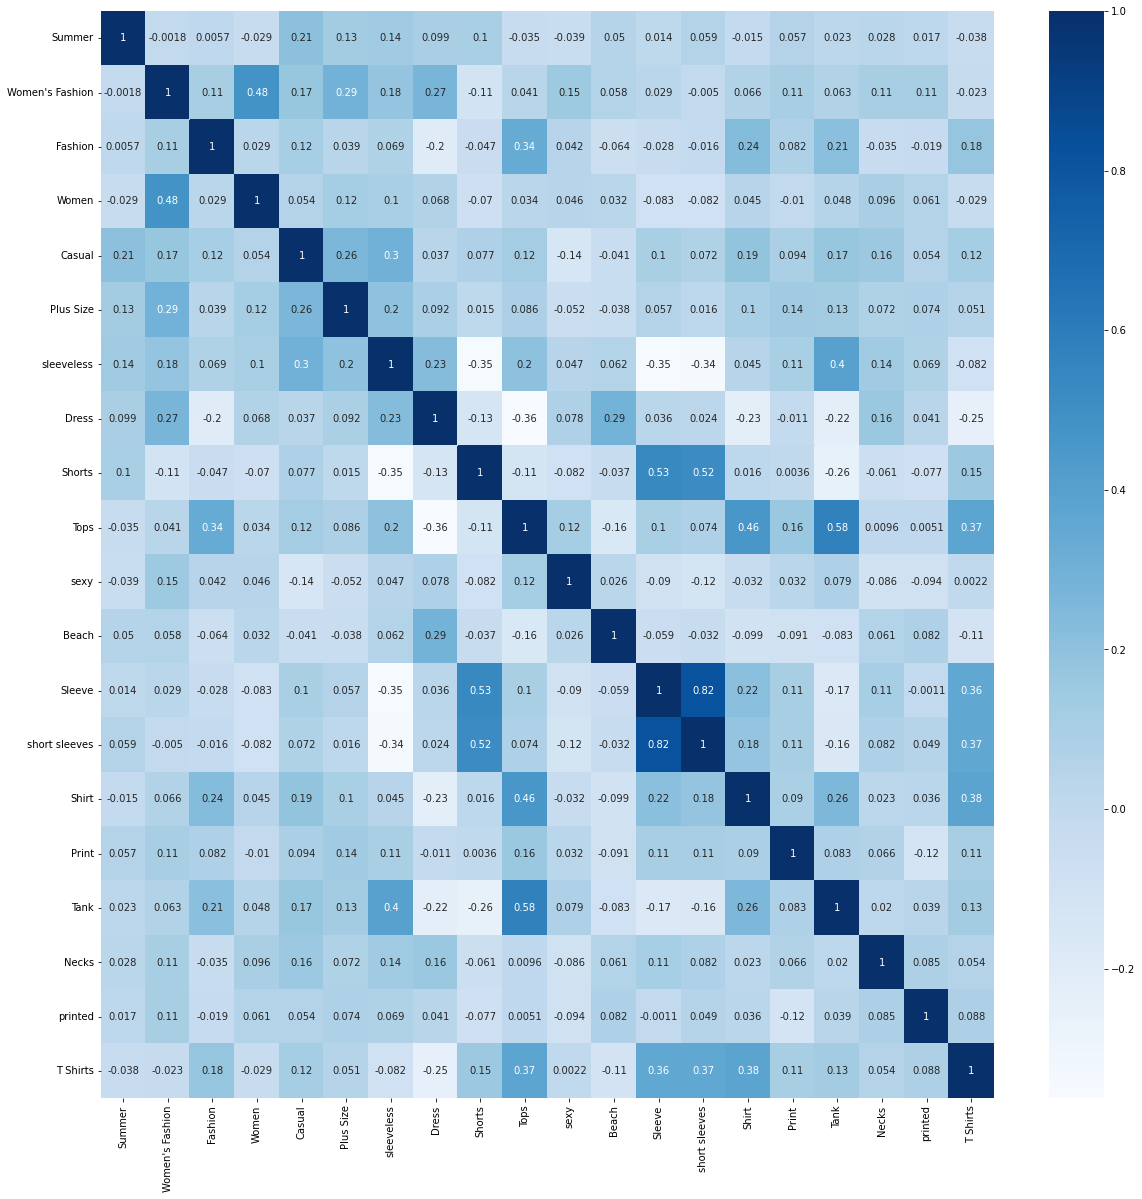

In [ ]:
import seaborn as sb
corr = tags_df[top_20_tags].corr()
plt.figure(figsize = (20,20))
sb.heatmap(corr, cmap="Blues", annot=True)

Wrong assumption

the is only high correlation between sleeve and short sleeves XD

Let's chose only the top 10 columns which have the heigher correlation with the rating column

In [ ]:
tags_corr_rating = tags_df.corrwith(df_train['rating']).abs().sort_values(ascending=False)

In [ ]:
#pick only the top 10 columns with high correlation (heigher than 0.15)
tags_high_corr_columns = tags_corr_rating[tags_corr_rating>0.15].index
tags_high_corr_columns

Index(['linenjumpsuit', 'women long pants', 'Women Rompers', 'waistgirdle',
       'slimming', 'wasitcincher', 'slimmingcorset', 'offshoulderjumpsuit',
       'printjumpsuit', 'spaghettishoulderstrapdre', 'minidressforwomen',
       'spaghettistrapdresse', 'womensfahsion', 'belt'],
      dtype='object')

In [ ]:
tags_high_corr_df = tags_df[tags_high_corr_columns]

### prepare data

In [ ]:
df_trail_4 = df_train.copy()

In [ ]:
#drop nominal columns
df_trail_4 = df_trail_4.drop(need_encoding_columns,axis = 1)
#drop has_urgency_banner 
df_trail_4 = df_trail_4.drop(to_fill_columns,axis = 1)

In [ ]:
#add tage encodes df
df_trail_4 = pd.concat([df_trail_4, tags_high_corr_df], axis=1)

In [ ]:
df_trail_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 0 to 1093
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price                      1063 non-null   float64
 1   retail_price               1063 non-null   int64  
 2   units_sold                 1063 non-null   int64  
 3   uses_ad_boosts             1063 non-null   int64  
 4   rating                     1063 non-null   float64
 5   rating_count               1063 non-null   int64  
 6   badge_local_product        1063 non-null   int64  
 7   badge_product_quality      1063 non-null   int64  
 8   badge_fast_shipping        1063 non-null   int64  
 9   shipping_option_price      1063 non-null   int64  
 10  shipping_is_express        1063 non-null   int64  
 11  merchant_rating            1063 non-null   float64
 12  linenjumpsuit              1063 non-null   int64  
 13  women long pants           1063 non-null   int64

In [ ]:
df_trail_4.isna().sum().sum()

0

In [ ]:
df_trail_4_x, df_trail_4_y = x_y_split(df_trail_4)

In [ ]:
df_trail_4_y.value_counts()

4.0    774
5.0    140
3.0    135
2.0     12
1.0      2
Name: rating, dtype: int64

###GridSearch
we will try three models with different parameters:
1. Decision tree
2. GradientBoostingClassifier

This time we will reduce our searching arae using the preivious results (the best prams from the preivous trials)

In [ ]:
#Scaling Data
scaler = preprocessing.StandardScaler()
df_trail_4_x_scaled = scaler.fit_transform(df_trail_4_x)

####Decision Tree

In [ ]:
#DecisionTreeClassifier()
dtreeparam_grid = {
    'criterion': ['gini'],
    'max_depth': np.arange(7,15),
    # 'min_samples_leaf': np.arange(10),
    'max_leaf_nodes': np.arange(45,65)
}

In [ ]:
param_list = [dtreeparam_grid]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_4_x_scaled,df_trail_4_y)

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_4_x_scaled,df_trail_4_y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce4d1c45d0>,
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini'],
                          'max_depth': array([ 7,  8,  9, 10, 11, 12, 13, 14]),
                          'max_leaf_nodes': array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
DecisionTree_resutls = pd.DataFrame(grid_search.cv_results_)
DecisionTree_best = [grid_search.best_score_ , grid_search.best_params_]
DecisionTree_resutls[DecisionTree_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005329,0.000179,0.002240,0.000157,gini,7,45,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.765258,0.774648,0.779343,0.797170,0.797170,0.782718,0.012642,2,0.837647,0.842353,0.845882,0.835488,0.829612,0.838196,0.005616
19,0.005165,0.000054,0.002104,0.000045,gini,7,64,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.769953,0.769953,0.779343,0.797170,0.797170,0.782718,0.012288,2,0.838824,0.842353,0.845882,0.835488,0.829612,0.838432,0.005612
23,0.006340,0.001784,0.002327,0.000080,gini,8,48,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.769953,0.779343,0.784038,0.806604,0.783019,0.784591,0.012076,1,0.843529,0.854118,0.856471,0.846063,0.837838,0.847604,0.006861
25,0.005630,0.000298,0.002386,0.000183,gini,8,50,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.769953,0.765258,0.793427,0.797170,0.783019,0.781765,0.012545,4,0.847059,0.856471,0.855294,0.847239,0.836663,0.848545,0.007120


####GradientBoosting

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'n_estimators': np.arange(80,120,10),
    'learning_rate' : [0.2,0.1]

}

In [ ]:
param_list = [GBC]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_4_x_scaled,df_trail_4_y)

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_4_x_scaled,df_trail_4_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce4d1c4ad0>,
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.1],
                          'n_estimators': array([ 80,  90, 100, 110])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
GBC_resutls = pd.DataFrame(grid_search.cv_results_)
GBC_best = [grid_search.best_score_ , grid_search.best_params_]
GBC_resutls[GBC_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,1.261022,0.004901,0.004996,0.000095,0.1,80,"{'learning_rate': 0.1, 'n_estimators': 80}",0.779343,0.765258,0.779343,0.811321,0.806604,0.788374,0.017643,3,0.908235,0.901176,0.897647,0.889542,0.897767,0.898874,0.006046
5,1.409158,0.011405,0.005236,0.000223,0.1,90,"{'learning_rate': 0.1, 'n_estimators': 90}",0.784038,0.769953,0.788732,0.806604,0.806604,0.791186,0.014024,2,0.915294,0.909412,0.904706,0.897767,0.902468,0.905929,0.005999
6,1.578294,0.013508,0.005612,0.000313,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.769953,0.769953,0.779343,0.806604,0.811321,0.787435,0.017970,4,0.922353,0.916471,0.915294,0.903643,0.914219,0.914396,0.006068
7,1.706667,0.057658,0.005397,0.000868,0.1,110,"{'learning_rate': 0.1, 'n_estimators': 110}",0.788732,0.779343,0.784038,0.806604,0.811321,0.794007,0.012655,1,0.923529,0.927059,0.922353,0.911868,0.924794,0.921921,0.005263


###Inspect results

In [ ]:
print('DT best f1-score:{0} , best prams:{1}'.format(DecisionTree_best[0],DecisionTree_best[1]))
print('GBC best f1-score:{0} , best prams:{1}'.format(GBC_best[0],GBC_best[1]))

DT best f1-score:0.7845911949685536 , best prams:{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 48}
GBC best f1-score:0.7940074408716449 , best prams:{'learning_rate': 0.1, 'n_estimators': 110}


The f1-score reduced :(

  but this is expexted as we are dropped some columns which means we lost some information

## Trial 5 (add color column)
* prepare color column 
* prepare data (drop nominal columns and has_urgency_banner column then add color column)
* use gridsearch (DT and GB only)
* inspect results 


###prepare tage column

In [ ]:
color_columns = df_train['product_color'].copy()

In [ ]:
color_columns.isna().sum()

26

In [ ]:
#we want to keep 85% of color and change the remaining 15% to others
#so we use the commulative sum to sum the persentages of colors in descending order
cumsum_color = (color_columns.value_counts()/color_columns.count()).cumsum()
cumsum_color

black               0.204436
white               0.365477
blue                0.437801
pink                0.503375
yellow              0.566056
                      ...   
lightgrey           0.996143
star                0.997107
lightyellow         0.998071
gold                0.999036
navyblue & white    1.000000
Name: product_color, Length: 85, dtype: float64

In [ ]:
#then apply our threshold
chosen_colors = cumsum_color[cumsum_color < 0.85].index
chosen_colors

Index(['black', 'white', 'blue', 'pink', 'yellow', 'red', 'green', 'grey',
       'purple', 'armygreen', 'winered', 'navyblue', 'multicolor', 'orange'],
      dtype='object')

In [ ]:
#change the value of other colors to other
color_columns[~color_columns.isin(chosen_colors)] = 'other'

In [ ]:
color_columns.value_counts()

black         212
other         184
white         167
blue           75
pink           68
yellow         65
red            61
green          61
grey           48
purple         36
armygreen      21
winered        19
navyblue       18
multicolor     14
orange         14
Name: product_color, dtype: int64

In [ ]:
color_columns.isna().sum()

0

In [ ]:
colors_df = color_columns.str.get_dummies(',')
colors_df

,armygreen,black,blue,green,grey,multicolor,navyblue,orange,other,pink,purple,red,white,winered,yellow
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1090,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1091,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1092,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### prepare data

In [ ]:
df_trail_5 = df_train.copy()

In [ ]:
#drop nominal columns
df_trail_5 = df_trail_5.drop(need_encoding_columns,axis = 1)
#drop has_urgency_banner 
df_trail_5 = df_trail_5.drop(to_fill_columns,axis = 1)

In [ ]:
#add tage encodes df
df_trail_5 = pd.concat([df_trail_5, colors_df], axis=1)

In [ ]:
df_trail_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 0 to 1093
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  1063 non-null   float64
 1   retail_price           1063 non-null   int64  
 2   units_sold             1063 non-null   int64  
 3   uses_ad_boosts         1063 non-null   int64  
 4   rating                 1063 non-null   float64
 5   rating_count           1063 non-null   int64  
 6   badge_local_product    1063 non-null   int64  
 7   badge_product_quality  1063 non-null   int64  
 8   badge_fast_shipping    1063 non-null   int64  
 9   shipping_option_price  1063 non-null   int64  
 10  shipping_is_express    1063 non-null   int64  
 11  merchant_rating        1063 non-null   float64
 12  armygreen              1063 non-null   int64  
 13  black                  1063 non-null   int64  
 14  blue                   1063 non-null   int64  
 15  gree

In [ ]:
df_trail_5.isna().sum().sum()

0

In [ ]:
df_trail_5_x, df_trail_5_y = x_y_split(df_trail_5)

In [ ]:
df_trail_5_y.value_counts()

4.0    774
5.0    140
3.0    135
2.0     12
1.0      2
Name: rating, dtype: int64

###GridSearch
we will try three models with different parameters:
1. Decision tree
2. GradientBoostingClassifier

In [ ]:
#Scaling Data
scaler = preprocessing.StandardScaler()
df_trail_5_x_scaled = scaler.fit_transform(df_trail_5_x)

####Decision Tree

In [ ]:
#DecisionTreeClassifier()
dtreeparam_grid = {
    'criterion': ['gini'],
    'max_depth': np.arange(7,15),
    # 'min_samples_leaf': np.arange(10),
    'max_leaf_nodes': np.arange(45,65)
}

In [ ]:
param_list = [dtreeparam_grid]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_5_x_scaled,df_trail_5_y)

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_5_x_scaled,df_trail_5_y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce4d1be3d0>,
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini'],
                          'max_depth': array([ 7,  8,  9, 10, 11, 12, 13, 14]),
                          'max_leaf_nodes': array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
DecisionTree_resutls = pd.DataFrame(grid_search.cv_results_)
DecisionTree_best = [grid_search.best_score_ , grid_search.best_params_]
DecisionTree_resutls[DecisionTree_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006262,0.001645,0.002160,0.000205,gini,7,45,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.746479,0.755869,0.774648,0.783019,0.778302,0.767663,0.014040,4,0.843529,0.845882,0.848235,0.836663,0.826087,0.840079,0.007994
1,0.005966,0.000558,0.002263,0.000092,gini,7,46,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.746479,0.751174,0.779343,0.783019,0.778302,0.767663,0.015531,4,0.843529,0.845882,0.849412,0.836663,0.826087,0.840315,0.008244
11,0.007461,0.003657,0.003265,0.002186,gini,7,56,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.746479,0.751174,0.779343,0.783019,0.778302,0.767663,0.015531,4,0.843529,0.845882,0.848235,0.837838,0.826087,0.840314,0.007907
15,0.005382,0.000057,0.002152,0.000251,gini,7,60,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.746479,0.746479,0.774648,0.787736,0.783019,0.767672,0.017805,2,0.843529,0.845882,0.848235,0.837838,0.826087,0.840314,0.007907
43,0.005773,0.000091,0.002044,0.000108,gini,9,48,"{'criterion': 'gini', 'max_depth': 9, 'max_lea...",0.751174,0.760563,0.779343,0.778302,0.773585,0.768593,0.010979,1,0.849412,0.857647,0.856471,0.854289,0.853114,0.854186,0.002869
58,0.006100,0.000402,0.001956,0.000129,gini,9,63,"{'criterion': 'gini', 'max_depth': 9, 'max_lea...",0.737089,0.751174,0.779343,0.783019,0.787736,0.767672,0.019909,2,0.863529,0.869412,0.868235,0.867215,0.864865,0.866651,0.002163


####GradientBoosting

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'n_estimators': np.arange(80,120,10),
    'learning_rate' : [0.2,0.1]

}

In [ ]:
param_list = [GBC]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_5_x_scaled,df_trail_5_y)

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_5_x_scaled,df_trail_5_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce4d1c4d50>,
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.1],
                          'n_estimators': array([ 80,  90, 100, 110])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
GBC_resutls = pd.DataFrame(grid_search.cv_results_)
GBC_best = [grid_search.best_score_ , grid_search.best_params_]
GBC_resutls[GBC_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.293018,0.021161,0.005462,0.000784,0.2,80,"{'learning_rate': 0.2, 'n_estimators': 80}",0.751174,0.774648,0.765258,0.797170,0.806604,0.778971,0.020368,1,0.967059,0.948235,0.960000,0.968273,0.964747,0.961663,0.007285
2,1.595759,0.013288,0.005666,0.000105,0.2,100,"{'learning_rate': 0.2, 'n_estimators': 100}",0.732394,0.779343,0.765258,0.801887,0.801887,0.776154,0.025954,3,0.982353,0.975294,0.980000,0.981199,0.972973,0.978364,0.003609
4,1.271831,0.004753,0.006361,0.002607,0.1,80,"{'learning_rate': 0.1, 'n_estimators': 80}",0.751174,0.755869,0.774648,0.806604,0.801887,0.778036,0.022845,2,0.905882,0.898824,0.898824,0.898942,0.910693,0.902633,0.004862
6,1.620717,0.008697,0.005556,0.000126,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.751174,0.760563,0.769953,0.792453,0.806604,0.776149,0.020486,4,0.928235,0.916471,0.921176,0.916569,0.924794,0.921449,0.004603


###Inspect results

In [ ]:
print('DT best f1-score:{0} , best prams:{1}'.format(DecisionTree_best[0],DecisionTree_best[1]))
print('GBC best f1-score:{0} , best prams:{1}'.format(GBC_best[0],GBC_best[1]))

DT best f1-score:0.7685933209318806 , best prams:{'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 48}
GBC best f1-score:0.7789706794224467 , best prams:{'learning_rate': 0.2, 'n_estimators': 80}


results are nearly the same as the first trial (with no nominal features)

## Trial 6 (add orgin country column)
* prepare orgin country column 
* prepare data (drop nominal columns and has_urgency_banner column then add orgin country column)
* use gridsearch (DT and GB only)
* inspect results

###prepare orgin country column

In [ ]:
df_train['origin_country'].value_counts()

CN    1023
US      22
VE       3
SG       2
GB       1
Name: origin_country, dtype: int64

In [ ]:
origin_country_columns = df_train['origin_country'].copy()

In [ ]:
origin_country_columns.isna().sum()

12

In [ ]:
#fill na with 'other'
origin_country_columns.fillna('other',inplace = True)

In [ ]:
origin_country_df = origin_country_columns.str.get_dummies(',')
origin_country_df

,CN,GB,SG,US,VE,other
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
1089,1,0,0,0,0,0
1090,1,0,0,0,0,0
1091,1,0,0,0,0,0
1092,1,0,0,0,0,0


### prepare data

In [ ]:
df_trail_6 = df_train.copy()

In [ ]:
#drop nominal columns
df_trail_6 = df_trail_6.drop(need_encoding_columns,axis = 1)
#drop has_urgency_banner 
df_trail_6 = df_trail_6.drop(to_fill_columns,axis = 1)

In [ ]:
#add tage encodes df
df_trail_6 = pd.concat([df_trail_6, origin_country_df], axis=1)

In [ ]:
df_trail_6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 0 to 1093
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  1063 non-null   float64
 1   retail_price           1063 non-null   int64  
 2   units_sold             1063 non-null   int64  
 3   uses_ad_boosts         1063 non-null   int64  
 4   rating                 1063 non-null   float64
 5   rating_count           1063 non-null   int64  
 6   badge_local_product    1063 non-null   int64  
 7   badge_product_quality  1063 non-null   int64  
 8   badge_fast_shipping    1063 non-null   int64  
 9   shipping_option_price  1063 non-null   int64  
 10  shipping_is_express    1063 non-null   int64  
 11  merchant_rating        1063 non-null   float64
 12  CN                     1063 non-null   int64  
 13  GB                     1063 non-null   int64  
 14  SG                     1063 non-null   int64  
 15  US  

In [ ]:
df_trail_6.isna().sum().sum()

0

In [ ]:
df_trail_6_x, df_trail_6_y = x_y_split(df_trail_6)

In [ ]:
df_trail_6_y.value_counts()

4.0    774
5.0    140
3.0    135
2.0     12
1.0      2
Name: rating, dtype: int64

###GridSearch
we will try three models with different parameters:
1. Decision tree
2. GradientBoostingClassifier

In [ ]:
#Scaling Data
scaler = preprocessing.StandardScaler()
df_trail_6_x_scaled = scaler.fit_transform(df_trail_6_x)

####Decision Tree

In [ ]:
#DecisionTreeClassifier()
dtreeparam_grid = {
    'criterion': ['gini'],
    'max_depth': np.arange(7,15),
    # 'min_samples_leaf': np.arange(10),
    'max_leaf_nodes': np.arange(45,65)
}

In [ ]:
param_list = [dtreeparam_grid]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_6_x_scaled,df_trail_6_y)

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_6_x_scaled,df_trail_6_y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce4d1c49d0>,
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini'],
                          'max_depth': array([ 7,  8,  9, 10, 11, 12, 13, 14]),
                          'max_leaf_nodes': array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
DecisionTree_resutls = pd.DataFrame(grid_search.cv_results_)
DecisionTree_best = [grid_search.best_score_ , grid_search.best_params_]
DecisionTree_resutls[DecisionTree_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
23,0.005110,0.000104,0.002253,0.000652,gini,8,48,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.779343,0.755869,0.784038,0.787736,0.792453,0.779888,0.012759,2,0.840000,0.850588,0.854118,0.840188,0.847239,0.846426,0.005610
25,0.005175,0.000199,0.002146,0.000268,gini,8,50,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.769953,0.769953,0.784038,0.783019,0.792453,0.779883,0.008744,3,0.841176,0.851765,0.855294,0.841363,0.848414,0.847602,0.005610
27,0.006856,0.003486,0.002069,0.000153,gini,8,52,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.769953,0.765258,0.784038,0.792453,0.787736,0.779888,0.010483,1,0.844706,0.852941,0.858824,0.842538,0.848414,0.849484,0.005855
38,0.005450,0.000363,0.002084,0.000036,gini,8,63,"{'criterion': 'gini', 'max_depth': 8, 'max_lea...",0.769953,0.755869,0.784038,0.792453,0.787736,0.778010,0.013377,4,0.850588,0.854118,0.860000,0.847239,0.850764,0.852542,0.004318


####GradientBoosting

In [ ]:
# GradientBoostingClassifier()
GBC = {
    'n_estimators': np.arange(80,120,10),
    'learning_rate' : [0.2,0.1]

}

In [ ]:
param_list = [GBC]

#prepare StratifiedKFold and use shuffle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(df_trail_6_x_scaled,df_trail_6_y)

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid = param_list ,
                           refit = True, cv= cv,return_train_score=True,
                           scoring = 'f1_micro',n_jobs=-1,verbose = 3)
grid_search.fit(df_trail_6_x_scaled,df_trail_6_y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fce4d1be550>,
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid=[{'learning_rate': [0.2, 0.1],
                          'n_estimators': array([ 80,  90, 100, 110])}],
             return_train_score=True, scoring='f1_micro', verbose=3)

In [ ]:
GBC_resutls = pd.DataFrame(grid_search.cv_results_)
GBC_best = [grid_search.best_score_ , grid_search.best_params_]
GBC_resutls[GBC_resutls['rank_test_score'] < 5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.225712,0.023243,0.005140,0.000177,0.2,80,"{'learning_rate': 0.2, 'n_estimators': 80}",0.769953,0.774648,0.784038,0.787736,0.801887,0.783652,0.011118,1,0.965882,0.955294,0.957647,0.951821,0.955347,0.957198,0.004724
4,1.222987,0.013211,0.005141,0.000097,0.1,80,"{'learning_rate': 0.1, 'n_estimators': 80}",0.760563,0.774648,0.765258,0.787736,0.806604,0.778962,0.016649,3,0.904706,0.904706,0.896471,0.886016,0.902468,0.898873,0.007100
5,1.368124,0.008103,0.005523,0.000194,0.1,90,"{'learning_rate': 0.1, 'n_estimators': 90}",0.760563,0.769953,0.769953,0.787736,0.806604,0.778962,0.016382,3,0.918824,0.912941,0.904706,0.895417,0.910693,0.908516,0.007958
6,1.540686,0.014908,0.005573,0.000161,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.769953,0.769953,0.779343,0.783019,0.811321,0.782718,0.015202,2,0.922353,0.915294,0.916471,0.898942,0.917744,0.914161,0.007977


###Inspect results

In [ ]:
print('DT best f1-score:{0} , best prams:{1}'.format(DecisionTree_best[0],DecisionTree_best[1]))
print('GBC best f1-score:{0} , best prams:{1}'.format(GBC_best[0],GBC_best[1]))

DT best f1-score:0.7798875011072727 , best prams:{'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 52}
GBC best f1-score:0.7836522278324032 , best prams:{'learning_rate': 0.2, 'n_estimators': 80}


results are nearly the same as the first trial (with no nominal features)


#Testing
Now we will use our best trial to predict the rating of test data.

Trial 3 is the best one. So we wil:
1. Train the model with highest f1-score
2. Prepare teat data as we did for training data in trail 3
3. Use the model for prediction

##train the model

In [ ]:
#Scaling Data
scaler = preprocessing.StandardScaler()
df_trail_3_x_scaled = scaler.fit_transform(df_trail_3_x)

In [ ]:
model = GradientBoostingClassifier(learning_rate = 0.2, n_estimators = 80)

In [ ]:
model.fit(df_trail_3_x_scaled,df_trail_3_y)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=80)

##prepare test data
1. Prepare tag column
2. Drop unnecessary columns
3. Change the shape of test_df to match the train_df

In [ ]:
tags_column_test = df_test['tags']

In [ ]:
tags_df_test = tags_column_test.str.get_dummies(',')
tags_df_test

,#Sport Bra,#Summer Clothes,#fashion #tshirt,#top #crop,2018fashion,2pieceset,34sleevedres,3D T-shirt,3dprint,3dprintedtshirt,5pointspant,90sfashion,A line dress,Accessories,Active,Adjustable Baseball Cap,Animal,Ankle,Ankle Strap,Anklets,Athletics,Bags,Balloon,Bandage Dresses,Bandages,Baseball,Baseball Cap,Bat,Bath,Bathing,Bathing Suits For Women,Bathroom,Battery,Beach,Beach Shorts,Beach Shorts Women,Beach slippers,Beading,Beauty,Bikini,...,women top,women trousers,women yoga pants,women's dress,women's jogging suits,women's pajamas,women's pants,women's plus size fashion,women's sleeveless tank,womenbikiniset,womenbohemiandre,womendressshirt,womenhotshirt,womenmonokini,womenonepiece,womens clothes,womens dresses,womens jeans,womens shirt,womens tank tops,womens top,womens vest,womensfahsion,womenshoessummer,womenshortpan,womenshortsleevedre,womensjumpsuitsromper,womenstraplessbra,womensundres,womenswimwearbikini,woven,wrappedchest,yoga leggings,yoga pants,yoga top,yogashort,yogavest,zippers,zippertop,шортымужские
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
475,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
476,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
477,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#drop nominal columns
df_test_v1 = df_test.drop(need_encoding_columns,axis = 1)
#drop has_urgency_banner 
df_test_v1 = df_test_v1.drop(to_fill_columns,axis = 1)

In [ ]:
df_test_v1.isna().sum()

price                             0
retail_price                      0
currency_buyer                    0
units_sold                        0
uses_ad_boosts                    0
rating_count                      0
badges_count                      0
badge_local_product               0
badge_product_quality             0
badge_fast_shipping               0
product_variation_inventory       0
shipping_option_name              0
shipping_option_price             0
shipping_is_express               0
inventory_total                   0
urgency_text                    355
merchant_title                    0
merchant_name                     0
merchant_info_subtitle            1
merchant_rating_count             0
merchant_rating                   0
merchant_id                       0
merchant_has_profile_picture      0
merchant_profile_picture        423
theme                             0
crawl_month                       0
id                                0
dtype: int64

In [ ]:
x_test = pd.concat([df_test_v1, tags_df_test], axis=1)

In [ ]:
diff_columns = list(set(df_trail_3_x.columns) - set(x_test.columns))

In [ ]:
#fill all different columns with zeros
x_test[diff_columns] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = value


In [ ]:
list(set(df_trail_3_x.columns) - set(x_test.columns))

[]

In [ ]:
#rearrange column order
x_test = x_test[df_trail_3_x.columns]

In [ ]:
#match the type for each column

x_test = x_test.astype(df_trail_3_x.dtypes)

In [ ]:
x_test

,price,retail_price,units_sold,uses_ad_boosts,rating_count,badge_local_product,badge_product_quality,badge_fast_shipping,shipping_option_price,shipping_is_express,merchant_rating,#Sport Bra,#fashion #shorts,#fashion #tshirt,#top #crop,2 Piece Swimsuit,2 piece dress sets,2014menshort,2014summermenshort,2018fashion,2in1short,2in1sportsjogging,2piecebathingsuit,2piecesbikini,2pieceset,34pant,34sleeve,34sleevedres,3D T-shirt,3dprint,3dprinttshirt,3mreflective,A line dress,A-line,Above Knee dresses,Accessories,Adidas,American,Angel,Animal,...,womenshortpant,womenshortspant,womensleepwearset,womensleevelessdres,womensportoutfit,womensportset,womensporttracksuit,womenssexyshort,womensummerclothe,womensummeroutfit,womensummersexybacklessbikini,womensummershort,womensummerswimwear,womenswimbottom,womenswimsit,womenswimwearbikini,womentee,womenunderwearsuit,workout top,workoutampyoga,workoutshortsformen,woven,wovenbag,wrap dress,wrapjumpsuit,wrappedchest,yoga leggings,yoga pants,yoga top,yoga2pcsset,yogaromper,yogashort,yogasuit,yogasuitset,yogateeshirt,yogavest,young,zippers,zippersleevelessvest,漁師の帽子
0,5.75,5,10,1,0,0,0,0,2,0,2.333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.00,7,5000,0,579,0,0,0,2,0,4.058391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.00,16,1000,1,62,0,0,0,2,0,4.029235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,18.00,27,5000,1,1903,0,0,0,5,0,4.052917,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12.00,81,20000,0,1799,0,0,0,3,0,4.127921,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,16.00,14,100,1,27,0,0,0,4,0,3.367133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
475,6.00,17,5000,1,817,0,0,0,2,0,4.079644,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
476,4.83,51,50,1,1,0,0,0,1,0,3.824561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
477,3.00,3,100,1,8,0,0,0,1,0,4.056169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_test_StandardScaler = scaler.transform(x_test)

##predict

In [ ]:
pred_test = model.predict(x_test_StandardScaler)

In [ ]:
df_test.id

0       937
1       270
2       308
3       913
4       403
       ... 
474    1166
475    1416
476      63
477     626
478     196
Name: id, Length: 479, dtype: int64

In [ ]:
pred_df = pd.DataFrame(data={'id': df_test.id, 'rating': pred_test})

In [ ]:
pred_df.rating.value_counts()

4.0    399
3.0     51
5.0     28
2.0      1
Name: rating, dtype: int64

In [ ]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      479 non-null    int64  
 1   rating  479 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.6 KB


In [ ]:
pred_df.to_csv('pred_walkthrough.csv', index=False)

#Answers to Questions

1. Why Data Mining is a misnomer? What is another preferred name?

* Because when someone hears the phrase "Data mining" he thinks that we mine for data like collecting data from many sources.
But what we do is mining the data, we extract knowledge from the data.

* Another preferred name is Mining Data
Or Mining the data or knowledge extraction

2. What is the general knowledge discovery process? What is the difference between a data engineer and data scientist/AI engineer?

3. In data mining, what is the difference between prediction and categorization?

4. Why data science/machine learning is a bad idea in the context of information security?
* Because models carries the informations of the training data for example using model weights we can reproduce the training set used for training the model. or we can know if a certain sample (image) is used for training the model by feeding the image to the model and observer the confidence. And we can find out if certain class wasn't included in the training set.

5. What is CIA principle and how can we use it to access the security/privacy aspect of the AI system/pipelines?
* CIA standa for Confidentiality,Integrity and Availability. We want to preserve these three components for every project.